In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from paos.core.parseConfig import parse_config
from paos.core.run import run
from paos.core.plot import simple_plot, plot_psf_xsec
import matplotlib.pyplot as plt

Hubble simple

In [3]:
pup_diameter, parameters, wavelengths, fields, opt_chains = parse_config('../lens data/Hubble_simple.ini')
wavelength, opt_chain = wavelengths[0], opt_chains[0]
ret_val = run(pup_diameter, 1.0e-6 * wavelength, parameters['grid_size'], parameters['zoom'], fields[0], opt_chain)

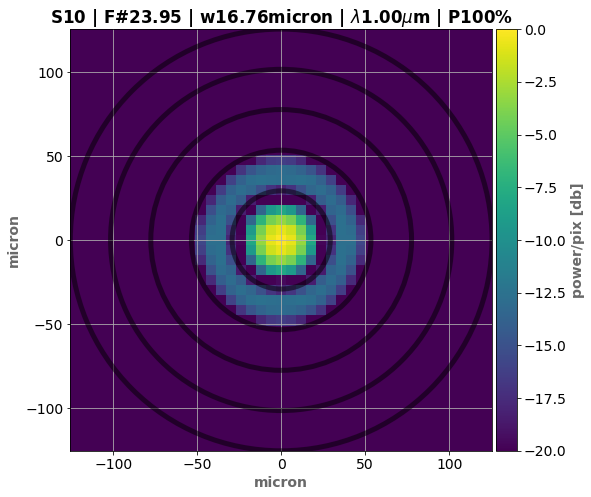

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
key = list(ret_val.keys())[-1]  # plot at last optical surface
item = ret_val[key]
simple_plot(fig, ax, key=key, item=item, ima_scale='log')
plt.show()

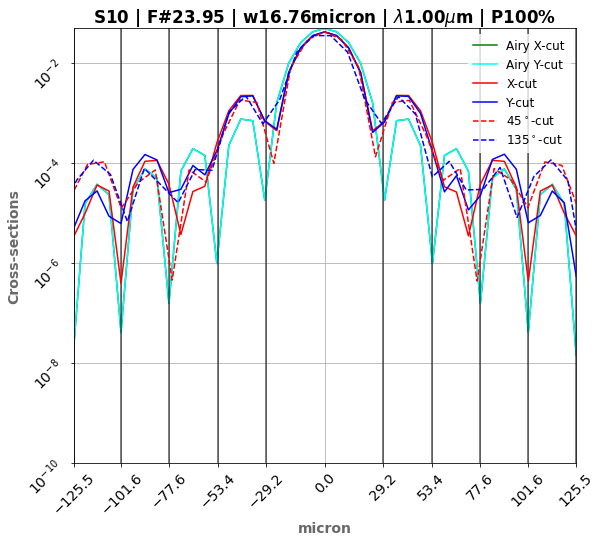

In [5]:
from paos.core.plot import plot_psf_xsec
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 8))
key = list(ret_val.keys())[-1]  # plot at last optical surface
item = ret_val[key]
plot_psf_xsec(fig, ax, key=key, item=item, ima_scale='log')
plt.show()

In [6]:
from paos.core.plot import plot_pop

plot_pop(ret_val, ima_scale='log', ncols=3, figname='figures/Hubble_simple.pdf')

Excite

In [7]:
pup_diameter, parameters, wavelengths, fields, opt_chains = parse_config('../lens data/Excite_TEL.ini')
wavelength, opt_chain = wavelengths[0], opt_chains[0]
ret_val = run(pup_diameter, 1.0e-6 * wavelength, parameters['grid_size'], parameters['zoom'], fields[0], opt_chain)

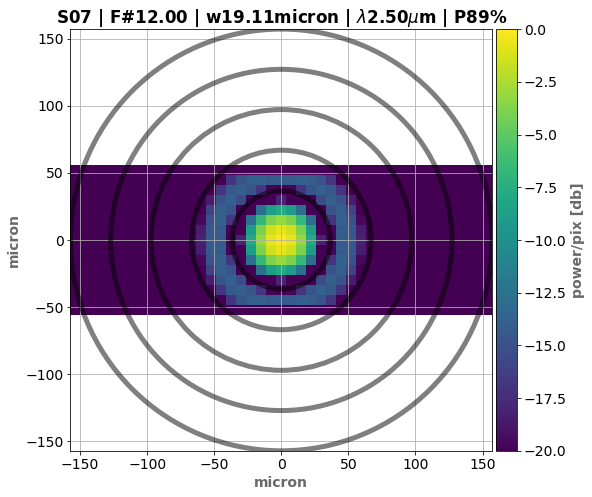

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
key = list(ret_val.keys())[-1]  # plot at last optical surface
item = ret_val[key]
simple_plot(fig, ax, key=key, item=item, ima_scale='log')
plt.show()

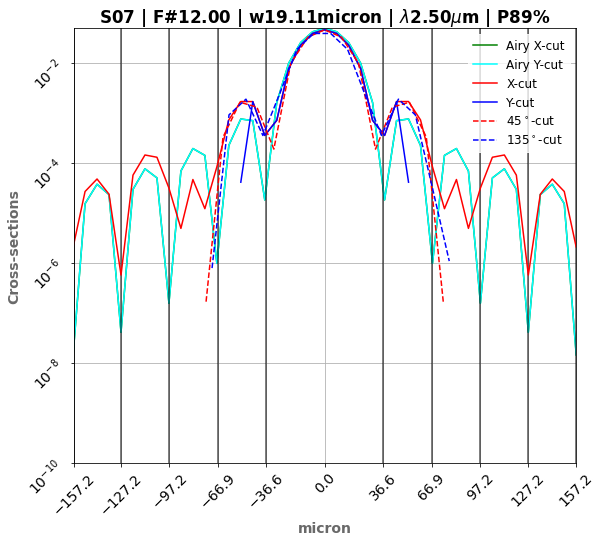

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 8))
key = list(ret_val.keys())[-1]  # plot at last optical surface
item = ret_val[key]
plot_psf_xsec(fig, ax, key=key, item=item, ima_scale='log')
plt.show()

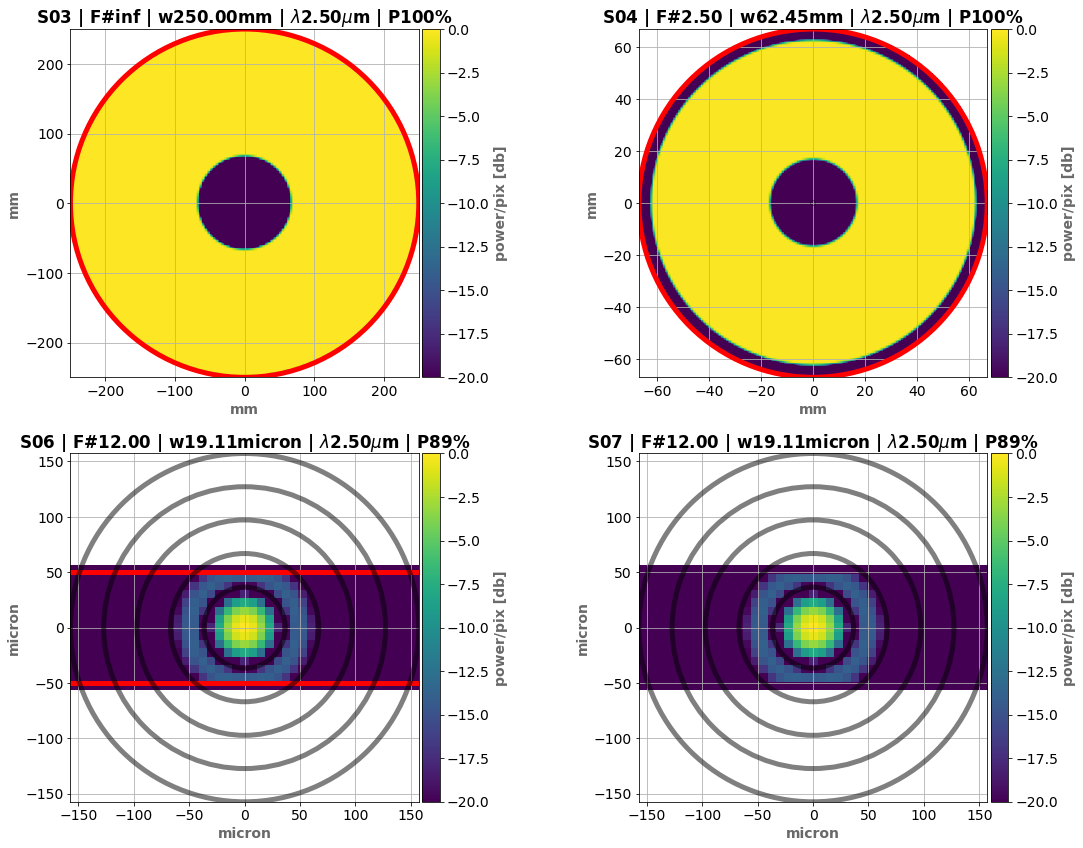

In [10]:
plot_pop(ret_val, ima_scale='log', ncols=2)

Ariel TA

In [11]:
pup_diameter, parameters, wavelengths, fields, opt_chains = parse_config('../lens data/lens_file_TA_Ground.ini')
wavelength, opt_chain = wavelengths[0], opt_chains[0]
ret_val = run(pup_diameter, 1.0e-6 * wavelength, parameters['grid_size'], parameters['zoom'], fields[0], opt_chain)

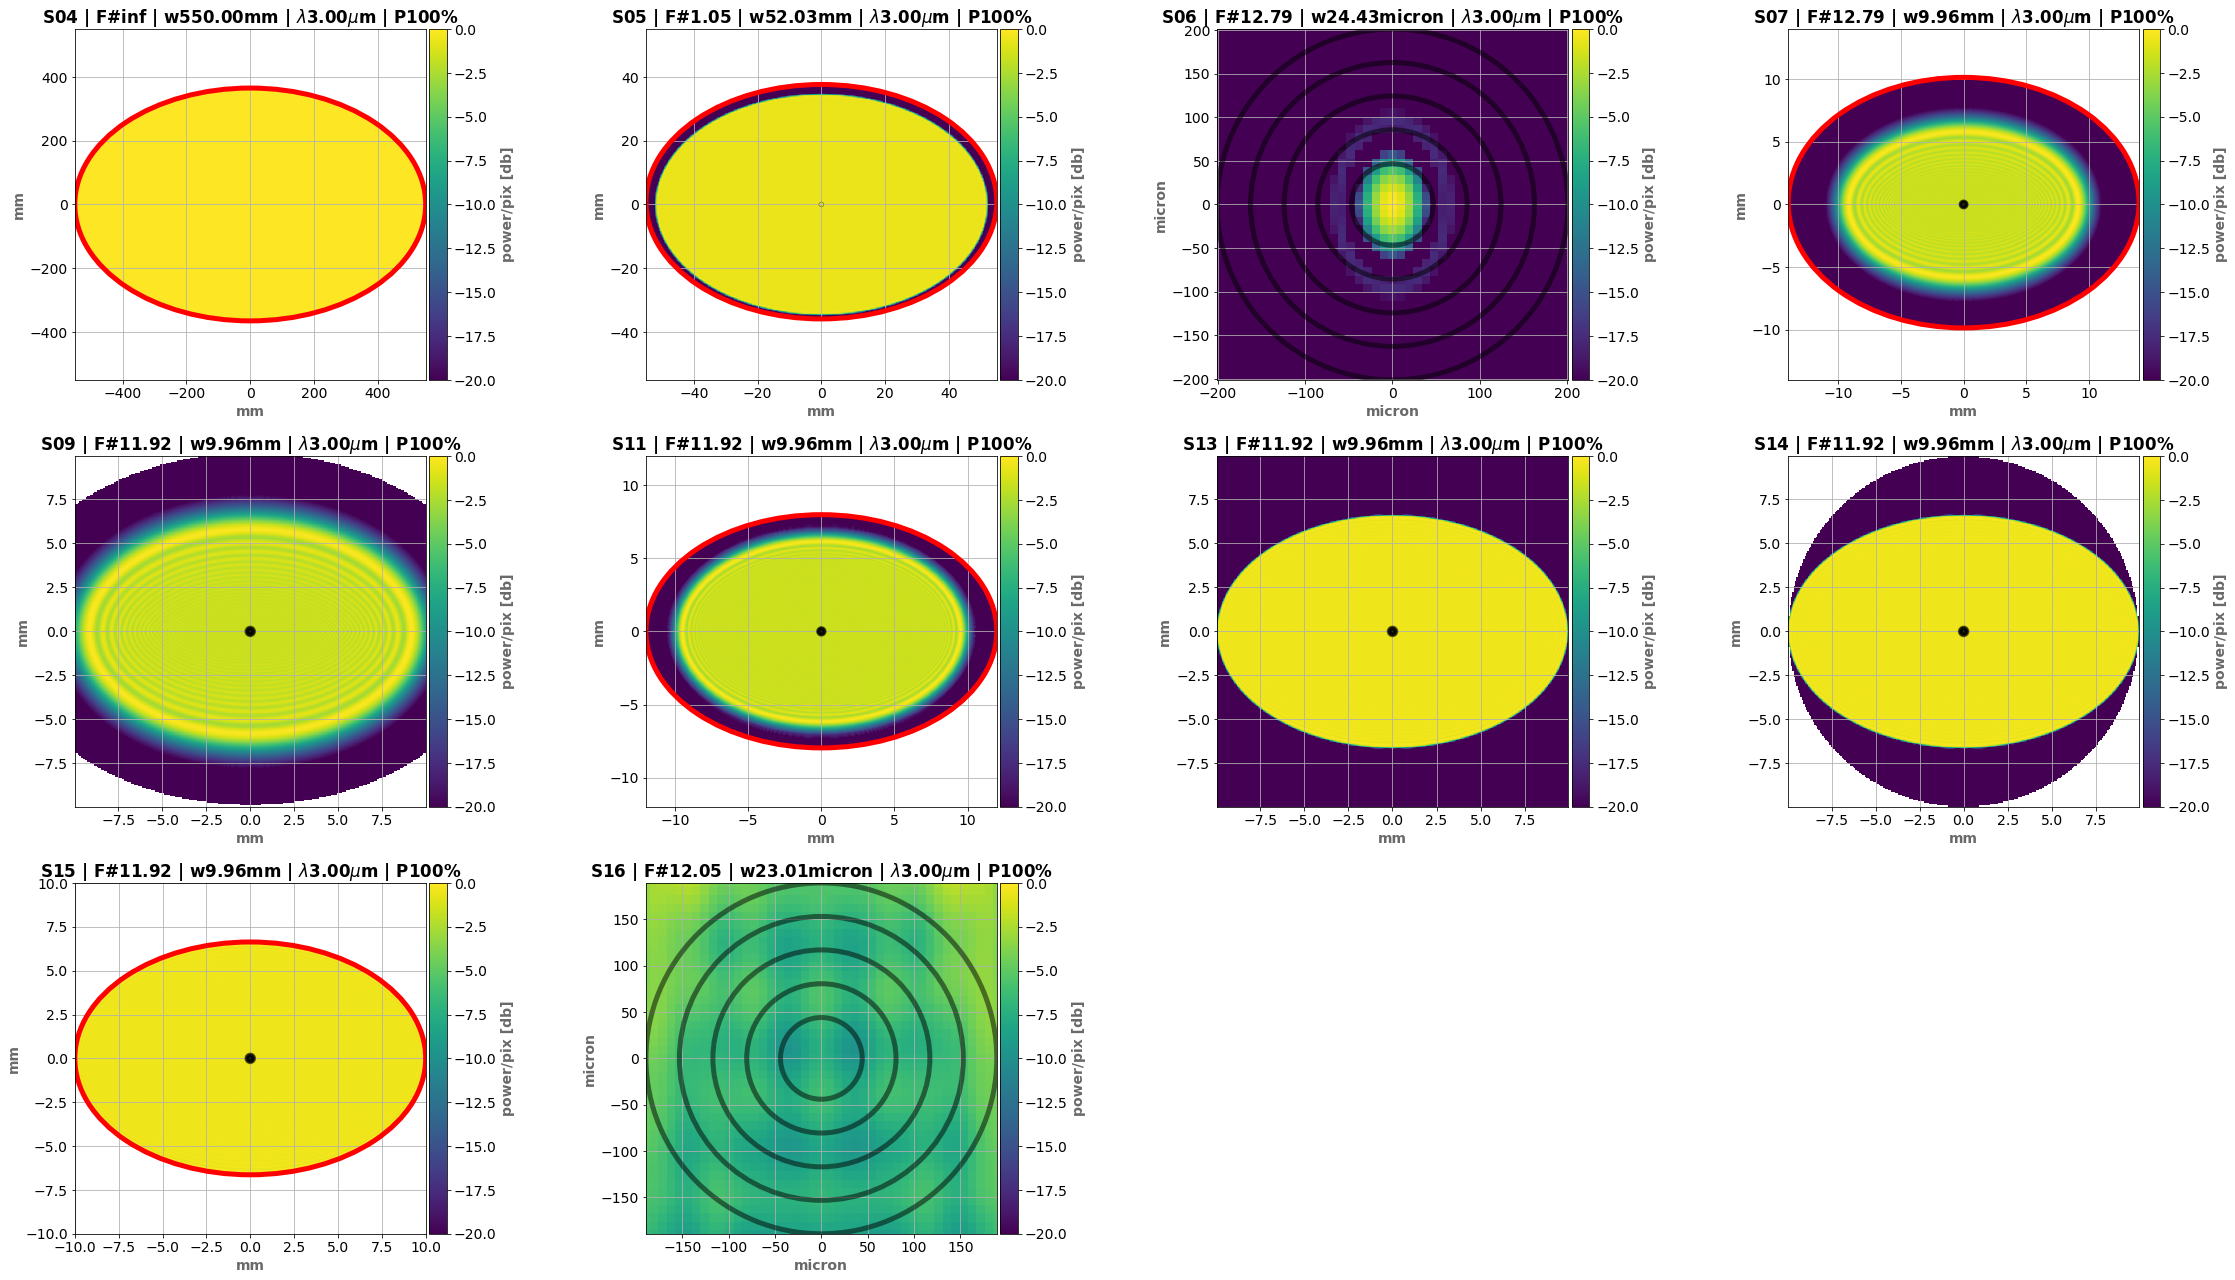

In [12]:
plot_pop(ret_val, ima_scale='log', ncols=4)

In [15]:
import numpy as np
from copy import deepcopy
from joblib import Parallel, delayed
from tqdm import tqdm

Npoly = 10
Nsims = Npoly - 3
Nsurf = 14

SFE = 50 * 1.0e-9  # m
Ck = np.vstack( (np.zeros( (3, Nsims) ), np.eye(Nsims) * 2 * SFE))

pup_diameter, parameters, wavelengths, fields, opt_chains = parse_config('../lens data/lens_file_TA_Ground.ini')
wavelength = 0.55  # micron
parameters['grid_size'] = 512
opt_chain = opt_chains[0]

opt_chain[Nsurf]['Zindex'] = np.arange(start=1, stop=Npoly+1)
opt_chain[Nsurf]['Zordering'] = 'ansi'
opt_chain[Nsurf]['Znormalize'] = 'True'
opt_chain[Nsurf]['Zorigin'] = 'x'

optc = []
for k in range(Nsims):
    temp = deepcopy(opt_chain)
    temp[Nsurf]['Z'] = Ck[:, k]
    optc.append(temp)

ret_val_list = Parallel(n_jobs=2)(delayed(run)(pup_diameter,
                                               1.0e-6 * wavelength,
                                               parameters['grid_size'],
                                               parameters['zoom'],
                                               fields[0],
                                               optc[i])
                                  for i in tqdm(range(Nsims)))

from paos.classes.zernike import Zernike

(m, n) = Zernike.j2mn(Npoly, opt_chains[0][Nsurf]['Zordering'])
n, m = n[3:], m[3:]
ncols = max(np.array([list(n).count(number) for number in set(n)]))
nrows = max(n)


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


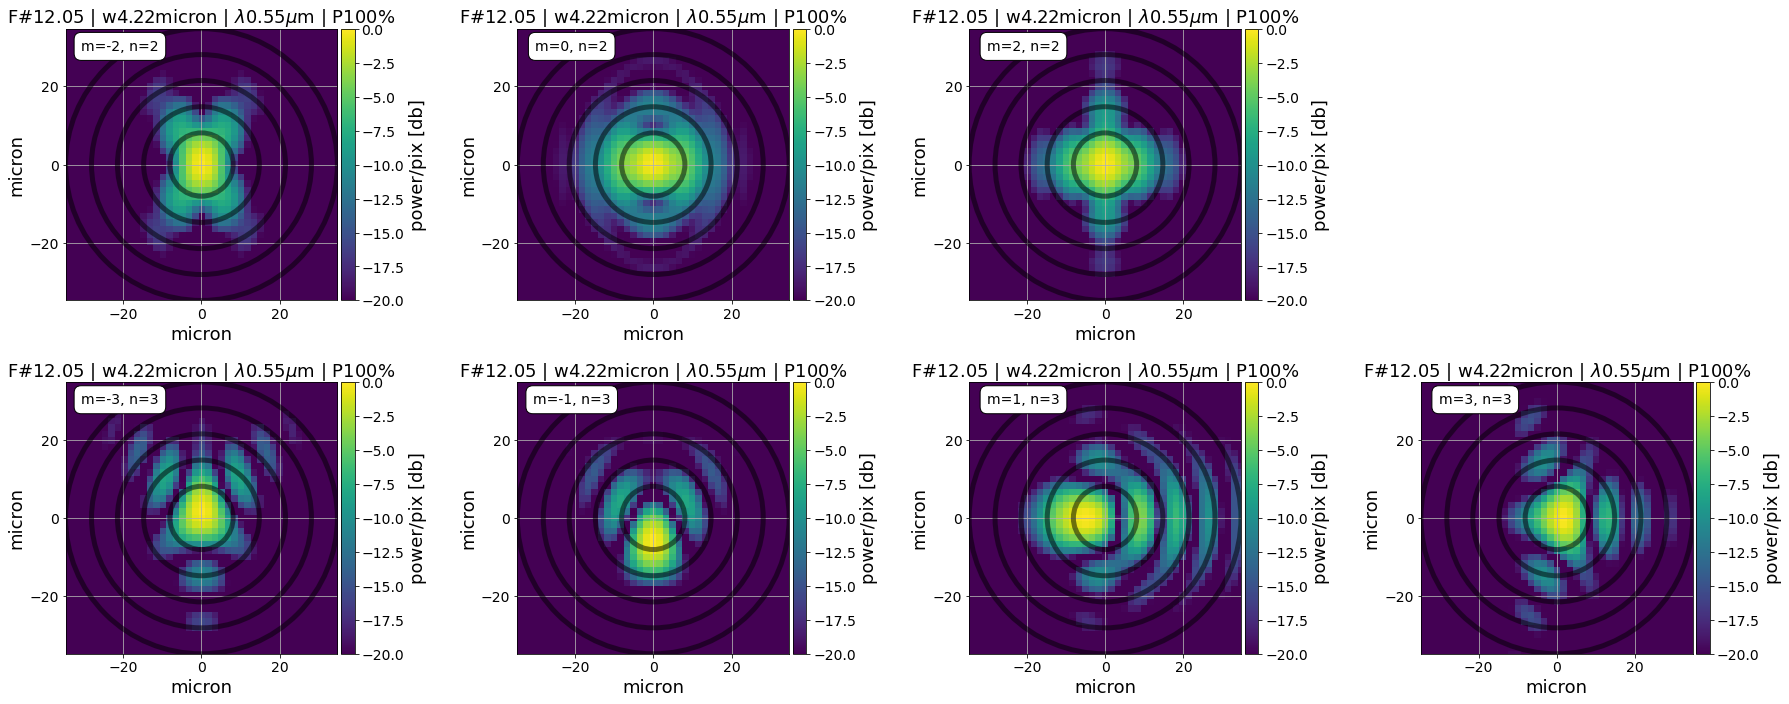

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8 * ncols, 6 * nrows))
plt.subplots_adjust(hspace=0.3, wspace=0.5)

sp = 1
for k, ret in enumerate(ret_val_list):

    key = list(ret.keys())[-1]  # plot at last optical surface
    item = ret[key]

    if item['wz'] < 0.005:
        # Use microns
        scale = 1.0e6
        unit = 'micron'
    else:
        # Use mm
        scale = 1.0e3
        unit = 'mm'

    axis = fig.add_subplot(nrows, ncols, sp)
    this_ncols = list(n).count(n[k])

    if sp % ncols < this_ncols:
        sp += 1
    else:
        sp += (ncols - this_ncols + 1)

    if 'psf' in item.keys():
        ima = np.ma.masked_array(data=item['psf'], mask=item['amplitude'] <= 0.0)
    else:
        ima = np.ma.masked_array(data=item['amplitude'] ** 2, mask=item['amplitude'] <= 0.0)
    power = ima.sum()

    kwargs = {'transform': axis.transAxes, 'horizontalalignment': 'center', 'fontsize': 14, 'color': 'black',
              'bbox': dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')}
    label = "m={:d}, n={:d}".format(m[k], n[k])
    axis.text(0.20, 0.92, label, **kwargs)

    simple_plot(fig, axis, key=key, item=item, ima_scale='log')
    axis.set_title(fr"F#{item['fratio']:.2f} | w{scale * item['wz']:.2f}{unit:s} | "
                   fr"$\lambda${1.0e6 * item['wl']:3.2f}$\mu$m | P{100 * power:2.0f}%", fontsize=18, fontweight="normal")
    axis.set_xlabel('micron', fontsize=18, fontweight='normal', color='black')
    axis.set_ylabel('micron', fontsize=18, fontweight='normal', color='black')
    # Change maxlocator to 4
    axis.xaxis.set_major_locator(plt.MaxNLocator(4))
    axis.yaxis.set_major_locator(plt.MaxNLocator(4))
    # remove colorbar from axis
    axis.images[0].colorbar.remove()

    cax = make_axes_locatable(axis).append_axes('right', size='5%', pad=0.05)
    clb = plt.colorbar(axis.images[0], cax=cax, orientation='vertical')
    clb.ax.tick_params(labelsize=14)
    clb.set_label('power/pix [db]', fontsize=18, fontweight='normal', color='black')

plt.subplots_adjust(hspace=0.3, wspace=0.05)
plt.savefig('figures/aberrations.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [12]:
ls

aberrations.png                 paos.log
ComputeABCD.ipynb               paos_validation_proper.ipynb
Compute_EquivalentLenses.ipynb  plot_examples.ipynb
mat.ipynb                       test_examples.ipynb
paos_ariel_example_v04.ipynb    ValidateThicklens.ipynb
paos_excite_example_v01.ipynb


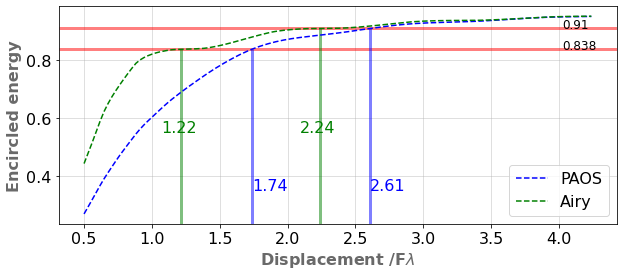

In [90]:
from scipy.special import j1
import photutils
encircled_energy = lambda x, ap: photutils.aperture_photometry(x, ap)['aperture_sum']

# 1st step
ret = ret_val_list[0]
_res_ = ret[list(ret.keys())[-1]]
ima = _res_['amplitude']**2

# 2nd step
phi_pup = 1.0
zoom    = parameters['zoom']
x       = zoom * np.linspace(-phi_pup, phi_pup, int(parameters['grid_size']))
x_i     = np.fft.fftshift(np.fft.fftfreq(int(parameters['grid_size']), d=0.5*(x[1]-x[0])))

# Airy 2D function, normalised to area 1
xx, yy = np.meshgrid(x_i, x_i)
r = np.pi * np.sqrt(xx ** 2 + yy ** 2) + 1.0e-30
airypsf = (2.0 * j1(r) / r) ** 2
normalization = 0.25 * np.pi * (x_i[1] - x_i[0]) * (x_i[1] - x_i[0])
airypsf *= normalization

# 3rd step
airyradius = 1.22 * _res_['fratio'] * wavelength * 1.0e-6 # Airy radius

# 4th step
minrad = airyradius / 1.22 / 2      # 0.5
maxrad = airyradius / 1.22 * 4.24   # 4th Airy null
radii = np.linspace(minrad, maxrad, 2 * 64)  # in units of meters

# 5th step
phi_x, phi_y = 0.1375, 0.09125
c = phi_x/phi_y

xy = parameters['grid_size'] // 2, parameters['grid_size'] // 2

# 6th step
eenc = np.zeros(radii.size)
dleenc = np.zeros(radii.size)
for i, r in enumerate(radii):
    r_a, r_b = r / _res_['dx'], r * c / _res_['dy']
    ap = photutils.EllipticalAperture(xy, r_a, r_b)
    eenc[i] = encircled_energy(ima, ap)
    dlap = photutils.CircularAperture(xy, r/ _res_['dx'])
    dleenc[i] = encircled_energy(airypsf, dlap)

# 7th step
radii = radii / airyradius * 1.22  # in units of [F wl]

# 8th step
def calc_inters_plot(ee, radii, points, axis, text_xoff, text_yoff, color, bottom):
    ee_intersections = []
    for point in points:
        temp = np.interp(point, ee, radii)
        ee_intersections.append(temp)
        axis.vlines([temp], bottom, point, color=color, linewidth=3, alpha=0.5)
        axis.text(temp - text_xoff, text_yoff, '{:.2f}'.format(temp), color=color)
    return ee_intersections

# 9th step
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
fig.patch.set_facecolor('white')

trsf = ax.get_xaxis_transform()
kwargs = {'transform': trsf, 'fontsize': 12, 'rotation': 90}
ax.plot(radii, eenc, '--b', label='PAOS')
ax.plot(radii, dleenc, '--g', label='Airy')
(left, right), (bottom, top) = ax.get_xlim(), ax.get_ylim()

#ax.vlines([1.22, 2.23], *(bottom, top), color='green', linewidth=3, alpha=0.5)
points = [0.838, 0.910]
ax.hlines(points, *(left, right), color='r', linewidth=3, alpha=0.5)
ee_intersections = calc_inters_plot(
    eenc, radii, points, ax, text_xoff=0., text_yoff=0.35, color='b', bottom=bottom)
_ = calc_inters_plot(
    dleenc, radii, points, ax, text_xoff=0.15, text_yoff=0.55, color='g', bottom=bottom)
for i, point in enumerate(points):
    ax.text( 0.95 * max(radii), point, str(point), fontsize=12, color='k')

ax.set_ylabel('Encircled energy')
ax.set_xlabel(r'Displacement /F$\lambda$')
ax.legend(loc='lower right')
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.4)
ax.relim()
ax.autoscale_view()

plt.show()

In [154]:
import matplotlib.pyplot as plt
import paos

xdec = ydec = 0.0
wfo = paos.WFO(beam_diameter=1.0, wl=3.0e-6, grid_size=512, zoom=4)
# wfo.aperture(xc=0.0, yc=0.0, r=0.5, shape='circular')
wfo.make_stop()

fl = 1.0  # m
wfo.lens(lens_fl=fl)
distance_to_focus = wfo.distancetofocus

wz = []
zr = []
# steps = np.hstack([0.0, np.repeat(fl/100, 200)])

# Steps is a logarithmic array of steps with 100 steps per decade
steps = np.logspace(np.log10(1e-10), np.log10(fl), 10 * 10)
# concatenate steps with the negative of steps, placed before the positive steps
steps = np.hstack([-steps[::-1], 0, steps[1:]])

for step in np.diff(steps):
    wfo.propagate(dz=step)
    wz.append(wfo.wz)
    zr.append(wfo.zr)

In [155]:
wz_formula = lambda z, z_ray, w0: w0 * np.sqrt(1 + (z / z_ray) ** 2)

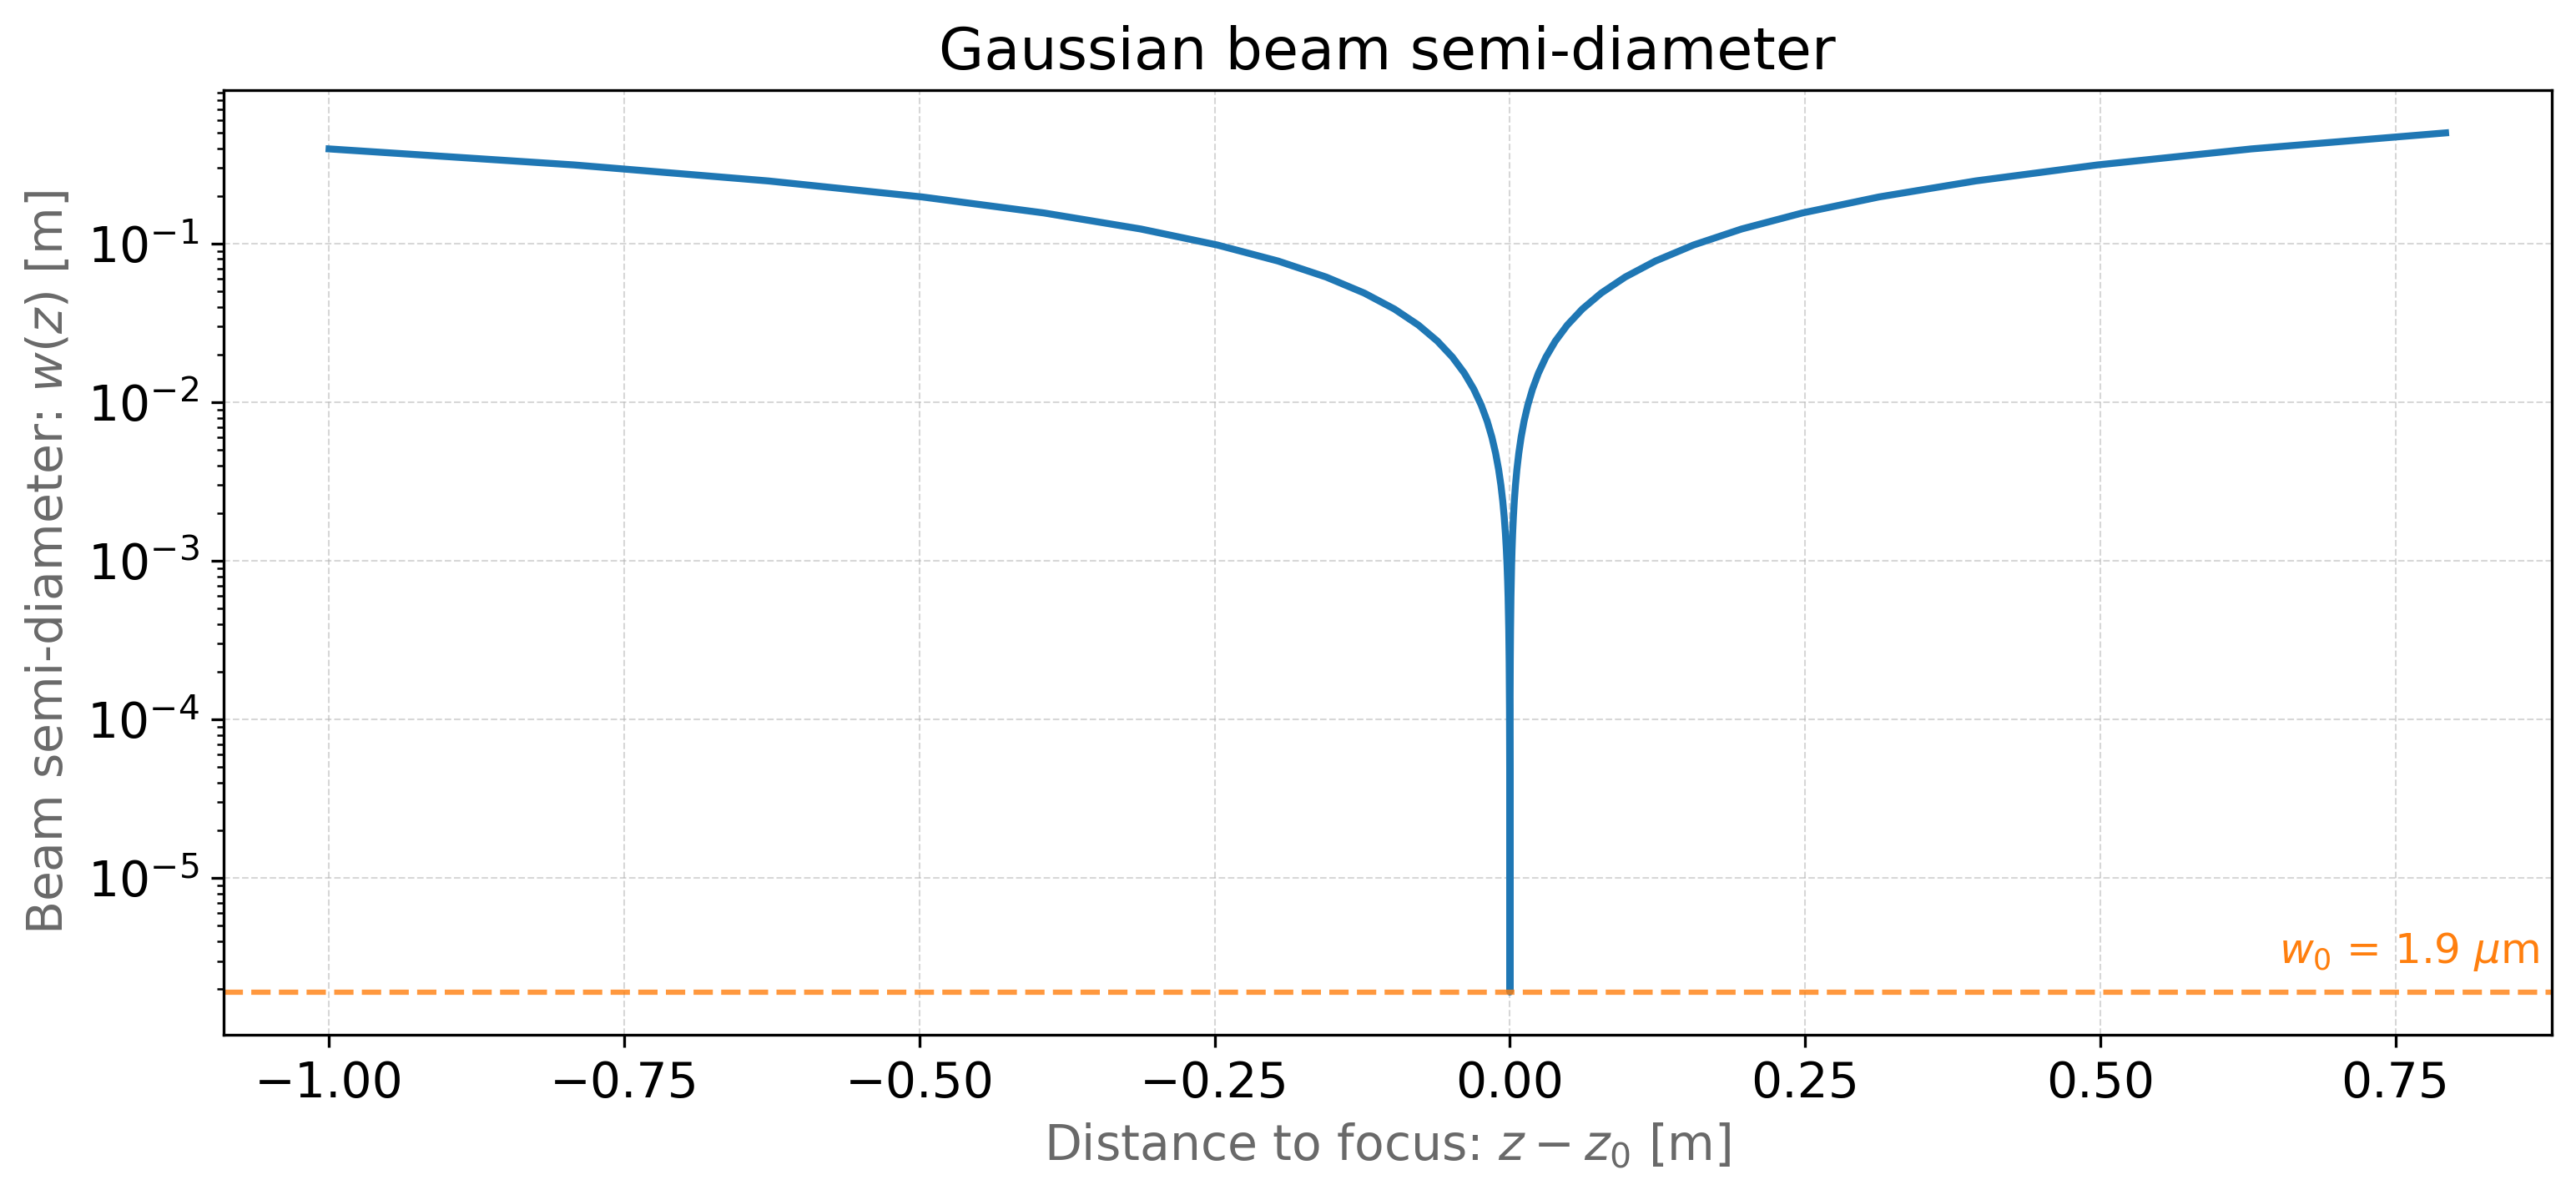

In [165]:
fig = plt.figure(figsize=(12, 5), dpi=300)
plt.title('Gaussian beam semi-diameter', fontweight='normal')

# wz_teo = wz_formula(steps[1:], zr, wz[np.argmin(wz)])
# plt.plot(steps[:-1], wz_teo, ms=2, lw=2, color='C0', label='Theoretical')
plt.plot(steps[:-1], wz, lw=2, color='C0')

plt.xlabel(r'Distance to focus: $z - z_0$ [m]', fontweight='normal')
plt.ylabel(r'Beam semi-diameter: $w(z)$' + ' [m]', fontweight='normal')

# Plot horizontal line at the beam waist
plt.axhline(np.array(wz).min(), color='C1', ls='--', lw=1.5, alpha=0.8)
# Write the beam waist value
plt.text(0.651, np.array(wz).min() + 1e-6, r'$w_0$ = {:.1f}'.format(np.array(wz).min() * 1e6) + ' $\mu$m',
         color='C1', fontweight='normal', fontsize=12)

plt.yscale('log')
plt.grid(lw=0.5, alpha=0.5, ls='--')
fig.savefig('gbeamprop.pdf', bbox_inches='tight', dpi=300)

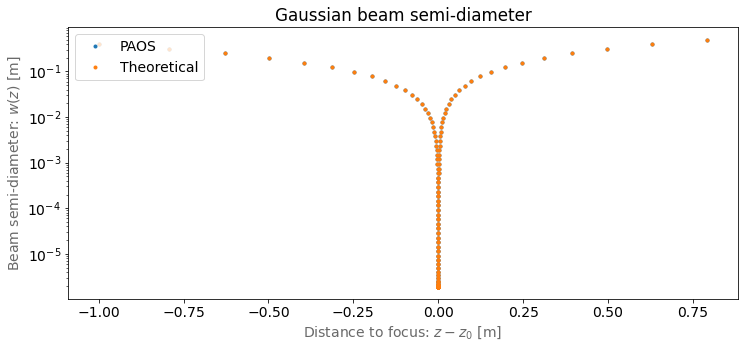

In [152]:
fig = plt.figure(figsize=(12, 5))
plt.title('Gaussian beam semi-diameter', fontweight='normal')
plt.plot(steps[:-1], wz, '.', lw=2, color='C0', label='PAOS')
plt.plot(steps[:-1], wz_teo, '.', lw=2, color='C1', label='Theoretical')
plt.xlabel(r'Distance to focus: $z - z_0$ [m]', fontweight='normal')
plt.ylabel(r'Beam semi-diameter: $w(z)$' + ' [m]', fontweight='normal')
plt.yscale('log')
plt.legend(loc='upper left')
plt.show()

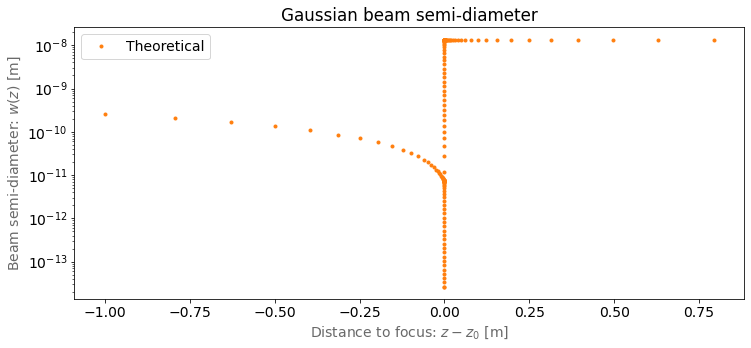

In [153]:
fig = plt.figure(figsize=(12, 5))
plt.title('Gaussian beam semi-diameter', fontweight='normal')
plt.plot(steps[:-1], wz_teo - wz, '.', lw=2, color='C1', label='Theoretical')
plt.xlabel(r'Distance to focus: $z - z_0$ [m]', fontweight='normal')
plt.ylabel(r'Beam semi-diameter: $w(z)$' + ' [m]', fontweight='normal')
plt.yscale('log')
plt.legend(loc='upper left')
plt.show()